Los árboles de decisión son representaciones gráficas de posibles soluciones a una decisión basada en ciertas condiciones, es uno de los algoritmos de aprendizaje supervizado más utilizados en machine learning y puede realizar tareas de clasificación o regresión.

Los árboles de decisión tienen un primer nodo llamado raíz (root) y luego se descomponen el resto de atributos de entrada en dos ramas (podrían ser más de dos ramas) planteando una condición que puede ser cierta o falsa. Se bifurca cada nodo en 2 y vuelven a sudividirse hasta llegar a las hojas que son los nodos finales y que equivalen a la solución (Si/No, Comprar/Vender).

El algoritmo es quien analiza los datos y las salidad, por eso es supervizado, dicidirá la mejor forma de hacer las divisiones (splits) entre nodos. Tendrá en cuenta de qué manera lograr una predicción (clasificación o regresión)

¿Cómo funciona un árbol de decisión?

Para obtener el árbol óptimo y valorar cada subdivisión entre todos los árboles posibles y conseguir el nodo raiz y los subsiguientes, el algoritmo deberá medir de alguna manera las predicciones logradas y valorarlas para comparar de entre todas y obtener la mejor. Para medir y valorar, utiliza diversas funciones, siendo las más conocidas y usadas los "indice gini" y "ganancia de información" que utiliza la denominada entropia. La división de nodos continuará hasta que lleguemos a la profundidad máxima posible del árbol o se limiten los nodos a una cantidad mínima de muestras de cada hoja.

* Indice Gini

Se utiliza para atributos con valores continuos (Ej: precio de una casa). Esta función de coste mide el "grado de impureza" de los nodos, es decir, cuán desordenados o mezclados quedan los nodos una vez divididos. Deberemos minimizar ese GINI index.

* Ganancia de información:

Se utiliza para atributos categóricos (Ej: hombre/mujer). Este criterio intenta estimar la información que aporta cada atributo basado en la "teoría de la información". Para medir la aleatoriedad de incertidumbre de un valor aleatorio de una variable "X" se define Entropia. Al obtener la medida de entropía de cada atributo, podemos calcular la ganancia de información del árbol. Debemos maximizar esa ganancia.

## Importación de las librerias

In [1]:
# Carga las librerias de trabajo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


Se utilizó un código python para hacer webscraping de una web pública "Ultimate Music Database" con información histórica edl Billboard del artículo: "Analyzing billboard 100". Luego se completo atributos utilizando la API de Deezer (duración de las canciones), la API de Gracenote (género y ritmo de las canciones). Finalmente se agrego varias fechar de nacimiento de artistas utilizando la Wikipedia.

## Pre análisis del DataFrame

In [2]:
# Carga el dataset
data = pd.read_csv('artists_billboard_fix3.csv')

# Muestra las primeras filas
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


A partir de atributos de cantantes y de un histórico de canciones que alcanzaron entrar al Billboard 100 (U.S) en 2013 y 2014 crearemos un árbol que nos permita intentar predecir si un nuevo cantante podrá llegar a número uno.

In [3]:
# Muestra el tamaño del dataset
data.shape

(635, 11)

In [4]:
# Muestra los nombres de las columnas
data. columns

Index(['id', 'title', 'artist', 'mood', 'tempo', 'genre', 'artist_type',
       'chart_date', 'durationSeg', 'top', 'anioNacimiento'],
      dtype='object')

El dataframe esta compuesto de 11 columnas (features) y 635 filas. Se tiene: titulo de canción, artista, mood o estado de animo de la canción, tempo, género, tipo de artista, fecha en que apareció en el billboard (Ej: 20140628 equivale al 28 de junio de 2024), la columna top la cual será la equiqueta, en la que aparece 1 si llegó al número uno de Billboard o 0 si no alcanzó, por último el año de nacimiento del artista. 

La mayoria de las columnas contiene información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que convendrá pasar a categórico más adelante.

In [5]:
# Muestra información del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              635 non-null    int64  
 1   title           635 non-null    object 
 2   artist          635 non-null    object 
 3   mood            635 non-null    object 
 4   tempo           635 non-null    object 
 5   genre           635 non-null    object 
 6   artist_type     635 non-null    object 
 7   chart_date      635 non-null    int64  
 8   durationSeg     635 non-null    float64
 9   top             635 non-null    int64  
 10  anioNacimiento  635 non-null    float64
dtypes: float64(2), int64(3), object(6)
memory usage: 54.7+ KB


Sobre la información del df podemos ver que las filas van desde 0 a 634 siendo un total de 635 filas, lo que indica junto a la columna id es que no hay filas faltantes en el medio. Además, se pude observar que no hay datos nulos en ninguna columna. Por último, tenemos 2 columnas tipo float64, 3 columnas tipo int64 y 6 columnas tipo object.

In [6]:
# Muestra la descripción estadística de las columnas numericas del dataset
data.describe()

,id,chart_date,durationSeg,top,anioNacimiento
count,635.000000,6.350000e+02,635.000000,635.000000,635.000000
mean,317.000000,2.013036e+07,321.768504,0.222047,1548.590551
std,183.452991,2.617996e+04,633.753787,0.415950,820.470454
min,0.000000,2.004021e+07,0.000000,0.000000,0.000000
25%,158.500000,2.014010e+07,200.000000,0.000000,1969.000000
50%,317.000000,2.014051e+07,232.000000,0.000000,1981.000000
75%,475.500000,2.014101e+07,266.500000,0.000000,1986.000000
max,634.000000,2.015031e+07,6840.000000,1.000000,1999.000000


Podemos observar que hay algunas canciónes que tienen duración en segundos igual a cero, el 50% de las canciones duran 232 segundos (3.86 minutos), cercano a la media que es de 321 segundos (5.35 minutos) y la de mayor duración es de 6840 segundos (114 minutos). Por otro lado, el año de nacimiento de los artista va desde 0 a 1999, esto se debe a los valores incompleto de algúnos de los artistas.

In [7]:
# Agurpa el dataset por el campo "top"
data.groupby('top').size()

top
0    494
1    141
dtype: int64

Devuelve que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad desbalanceada de etiquetas entre canciones que llegaron al top y las que no lo hicieron.

## Visualización de los atributos de entrada

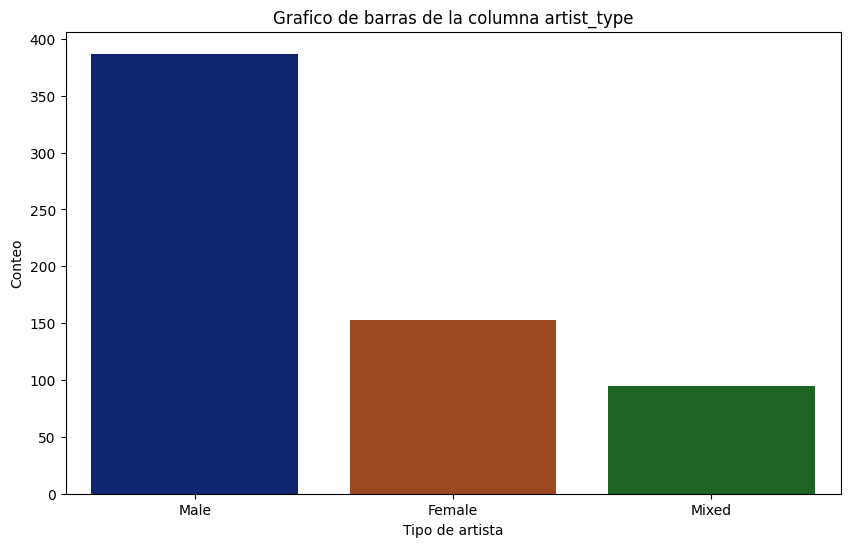

In [8]:
# Grafica de la columna artist_type
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='artist_type', palette='dark')

plt.title('Grafico de barras de la columna artist_type')
plt.xlabel('Tipo de artista')
plt.ylabel('Conteo')
plt.show()

Se observa que tenemos más del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas.

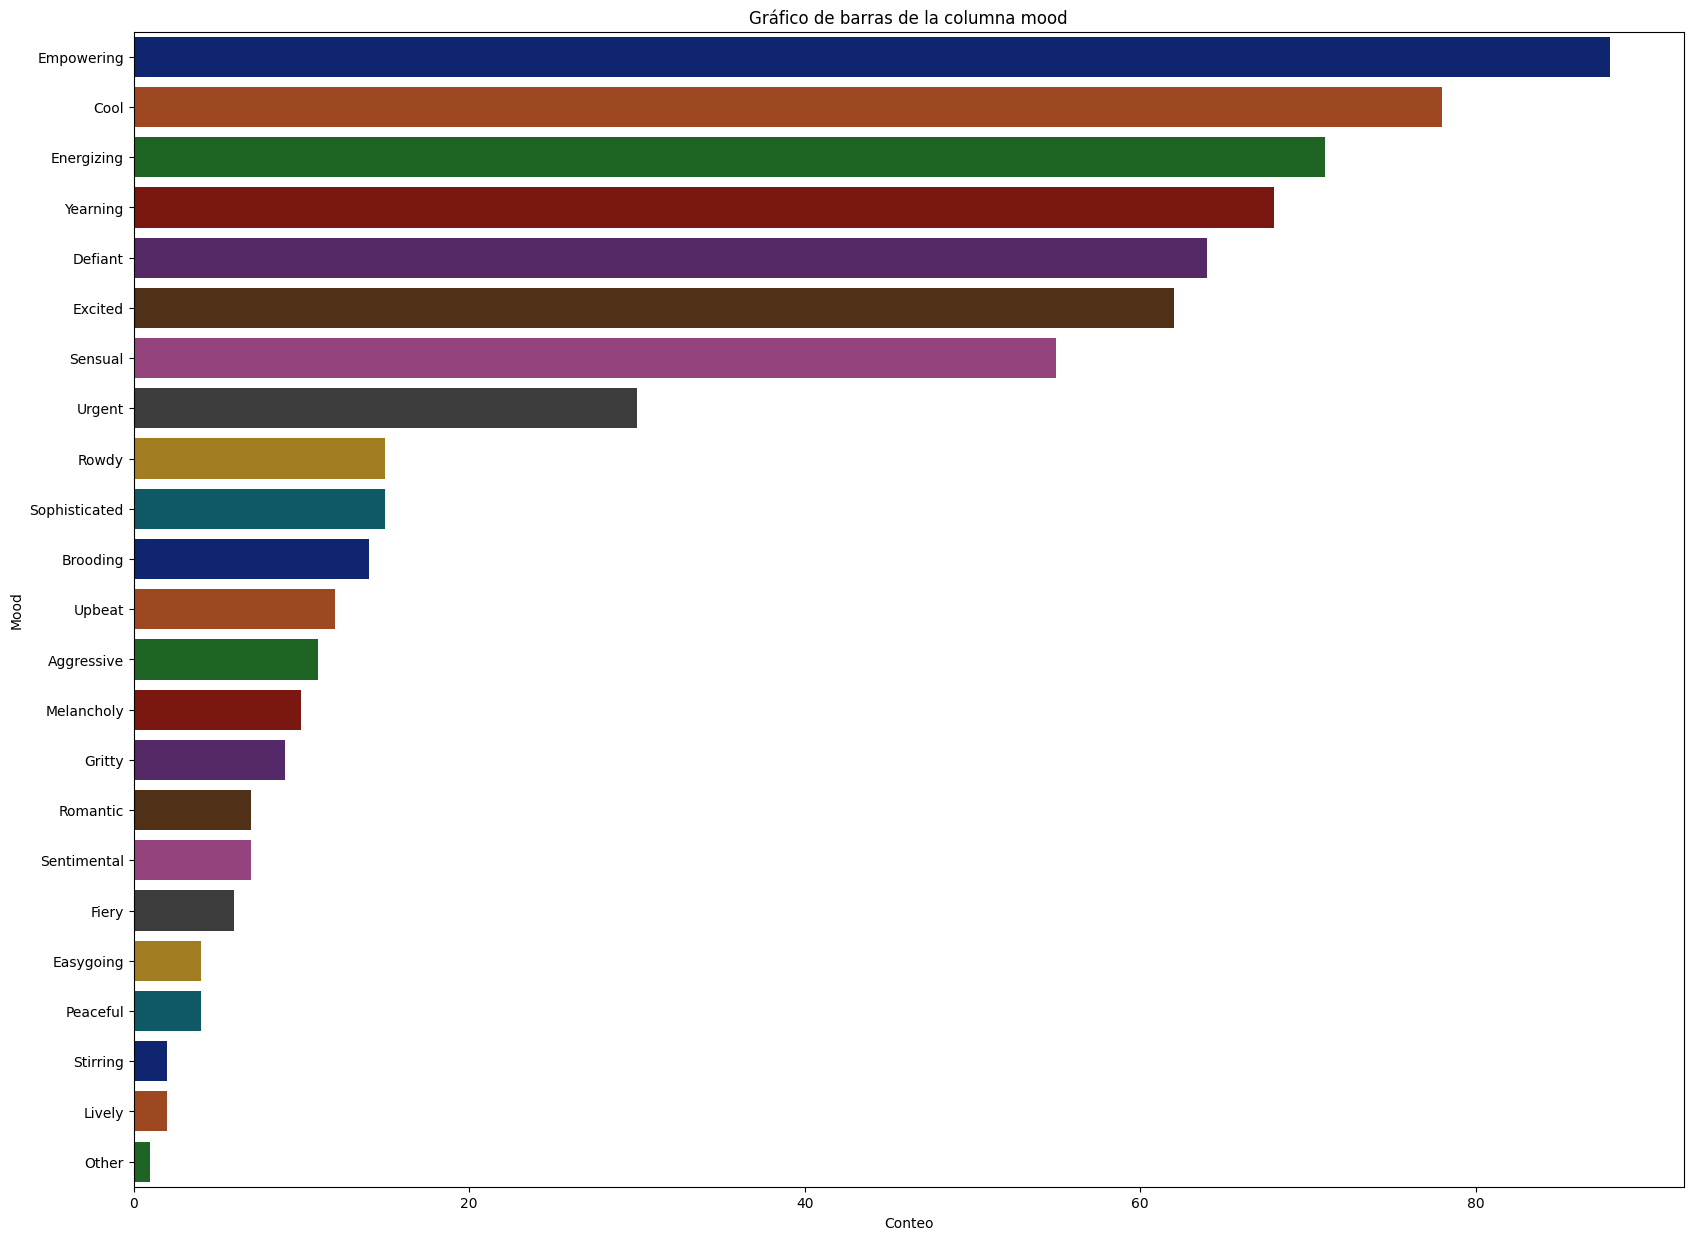

In [9]:
# Grafica de la columna mood
plt.figure(figsize=(20, 15))
plt.yticks(rotation=0)  # Rotar etiquetas en el eje y si es necesario
sns.countplot(data=data, y='mood', order=data['mood'].value_counts().index, palette='dark')
plt.title('Gráfico de barras de la columna mood')
plt.xlabel('Conteo')
plt.ylabel('Mood')
plt.show()

Se observan 23 tipos de ánimo similares, destacando 7 con picos altos (Empowering, Cool, Energizing, Yearning, Defiant, Excited y Sensual) y varios estados similares.

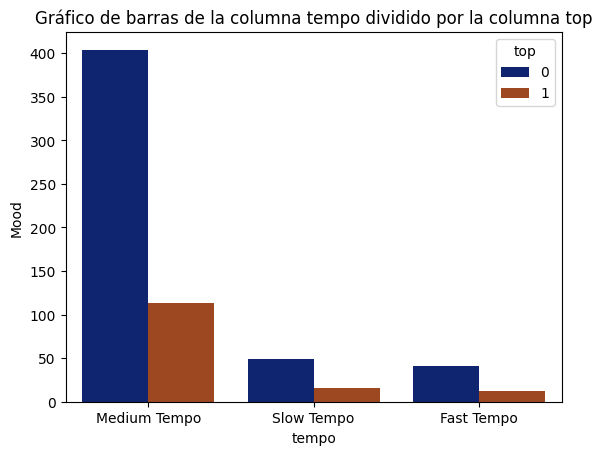

In [31]:
# Grafica de la columna tempo dividido por la columna top
sns.countplot(data=data, x='tempo', hue='top', palette='dark')
plt.title('Gráfico de barras de la columna tempo dividido por la columna top')
plt.ylabel('Mood')
plt.show()

En esta gráfica se observa que hay 3 tipos distintos de tempo: Medim, Slow y Fast. Predomina el tempo Medium y es donde encontramos más canciones que hayan alcanzado el Top 1.

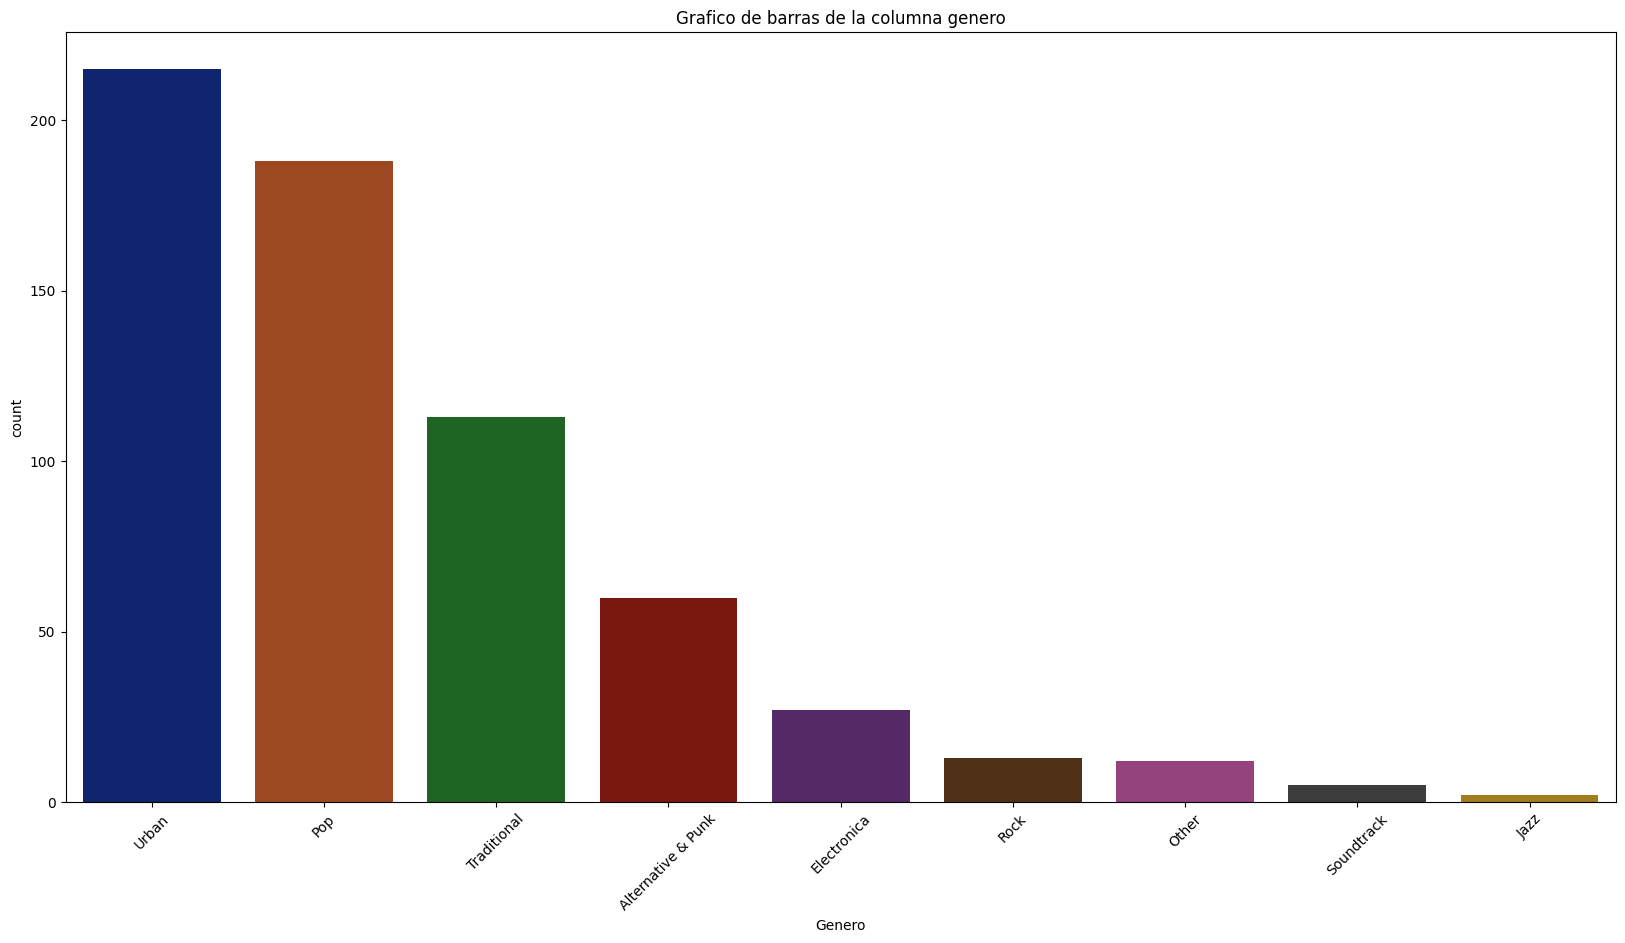

In [11]:
# Grafica de la columna genre
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='genre', order=data['genre'].value_counts().index,palette='dark')
plt.xticks(rotation=45)
plt.title('Grafico de barras de la columna genero')
plt.xlabel('Genero')
plt.show()

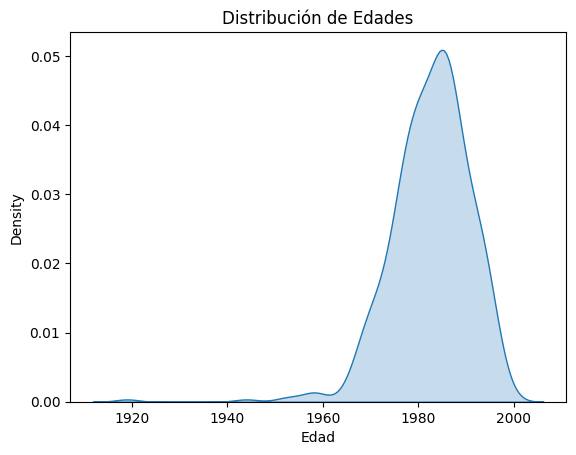

In [38]:
sns.kdeplot(data['anioNacimiento'], fill=True)
plt.xlabel('Edad')
plt.title('Distribución de Edades')
plt.show()

Se observan en la gráfica que hay cerca de 140 canciones de las cuales se desconoce el año de nacimiento del artista. Además, se ve que los años de nacimiento de los artista va desde 1954 a 1981.

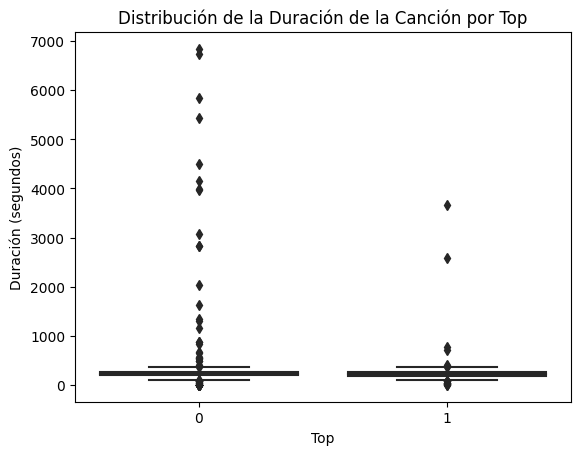

In [40]:
sns.boxplot(data=data, x='top', y='durationSeg', palette='dark')
plt.title('Distribución de la Duración de la Canción por Top')
plt.xlabel('Top')
plt.ylabel('Duración (segundos)')
plt.show()

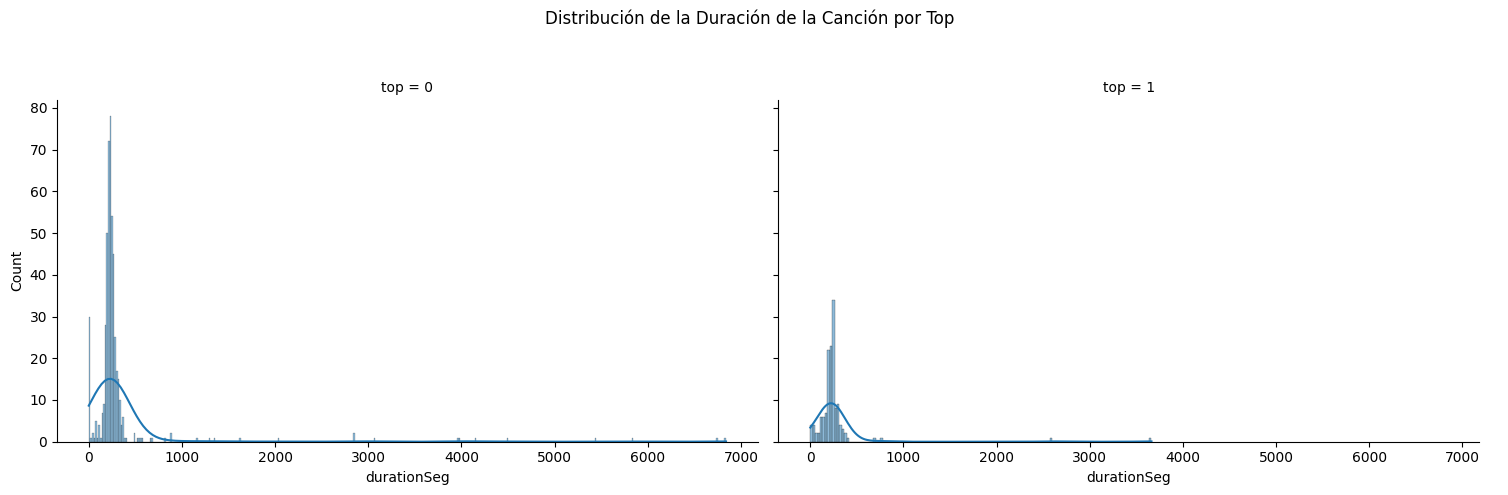

In [46]:
g = sns.FacetGrid(data, col='top', height=5, aspect=1.5)
g.map(sns.histplot, 'durationSeg', kde=True)
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Distribución de la Duración de la Canción por Top')
plt.show()

Podemos observar que la columna que contiene la duración de las canciones contiene valores de duración muy altos, habrá que analizar si esto se trata de un error o que decisión se puede tomar con estos valores. Tambien se observa que más allá de una duración de alrededor 3500 segundos (55,33 minutos), no hay canciones que hayan llegado al top.

## Balanceo de datos

Como se observo antes, no tenemos "equilibrio" en la cantidad de etiquetas 'top' y 'no top' de las canciones. Esto se debe a que en el transcurso de un año, pocas canciones logran el primer puesto y se mantiene durante varias semanas en ese puesto. 

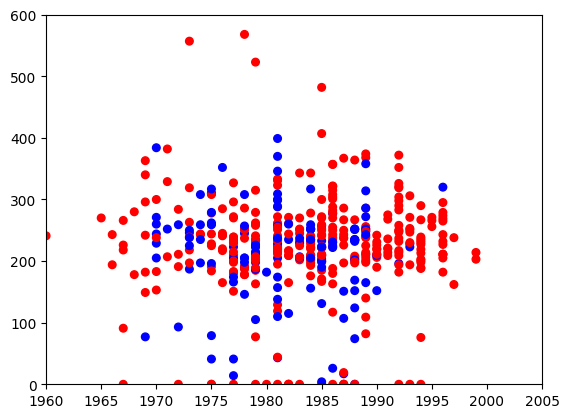

In [13]:
colores = ['red', 'blue']

# visualización de top y no top de acuerdo a su fecha de aparición en los billboards 
f1 = data['anioNacimiento'].values
f2 = data['durationSeg'].values

asignar = []
for index, row in data.iterrows():
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960, 2005, 0, 600])
plt.show()

No se observa ningún patron a simple vista, los top y no tops están bien distribuidos.

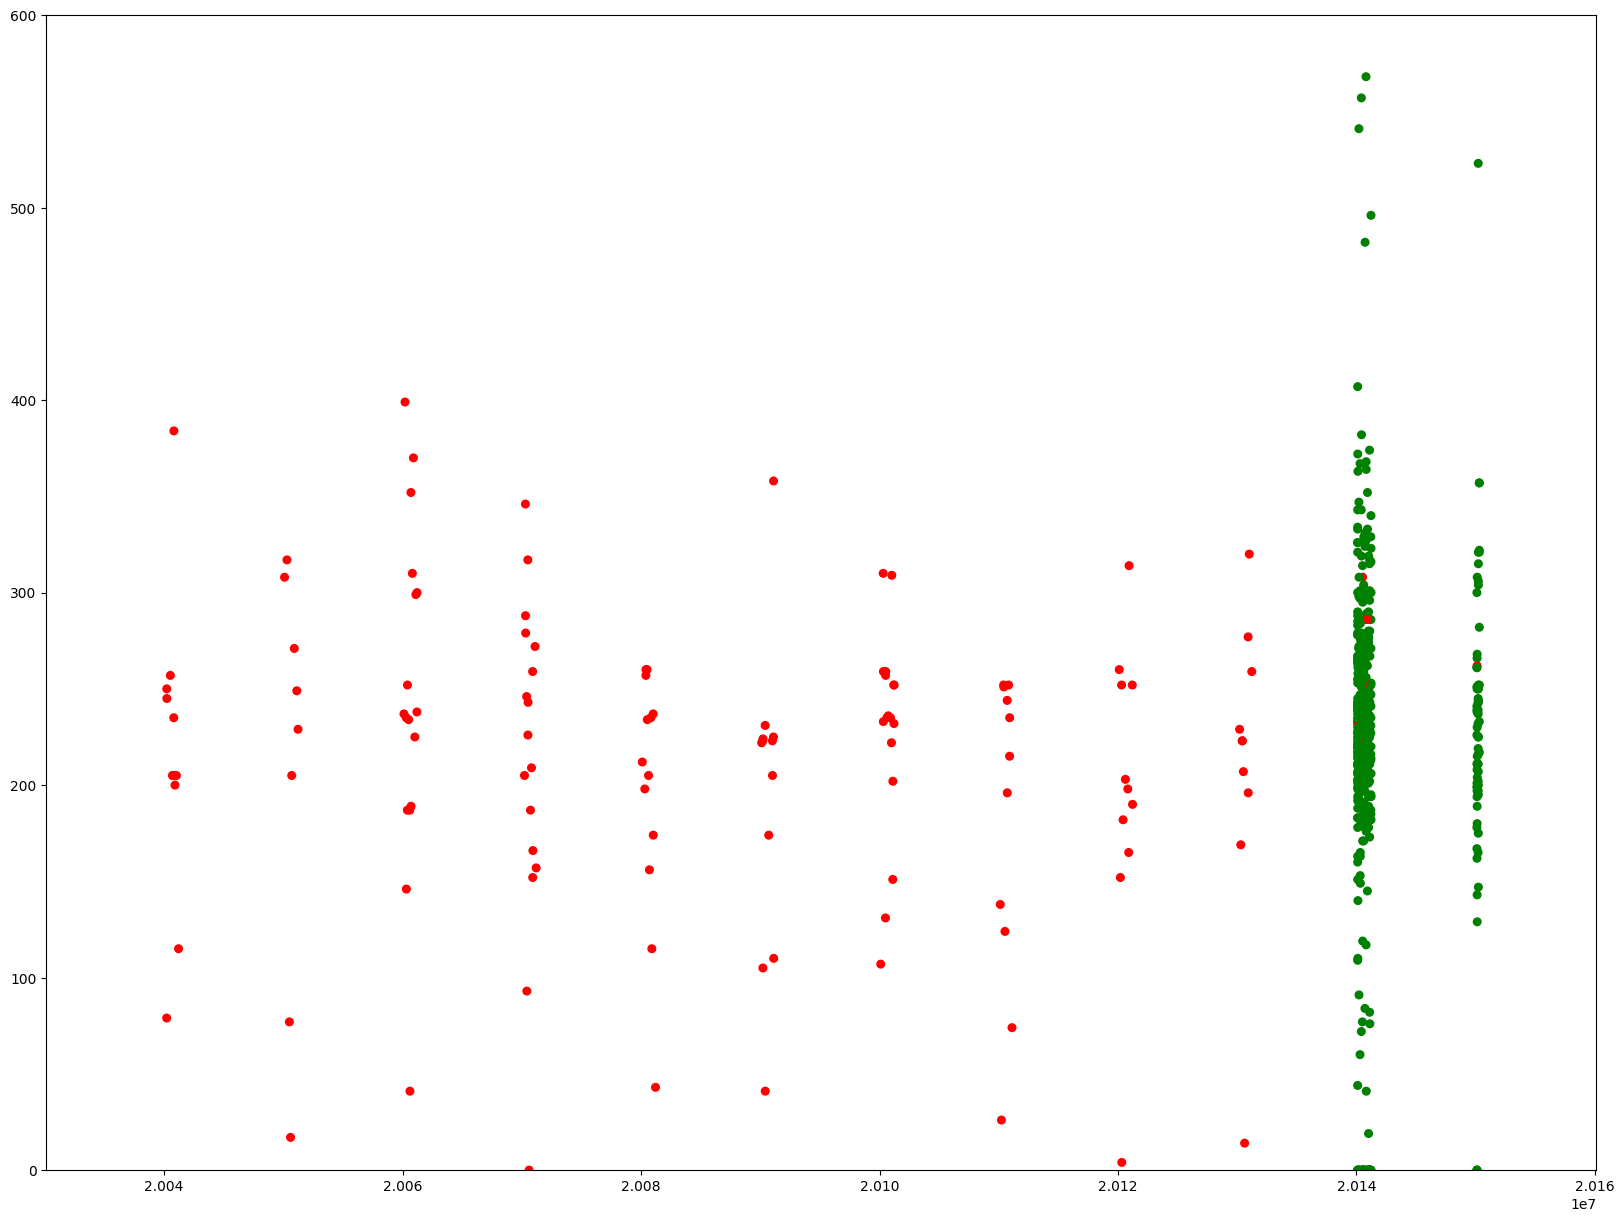

In [14]:
colores = ['green', 'red']
tamanios = [30, 30]
plt.figure(figsize=(20, 15))

# visualización de top y no top de acuerdo a su duración
f1 = data['chart_date'].values
f2 = data['durationSeg'].values

asignar = []
asignar2 = []
for index, row in data.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101,20160101,0,600])
plt.show()

## Preparación de los datos

### Columna anioNacimiento

Primero se procede arreglar los años de nacimiento que están en cero. El "feature" o característica que queremos obtener es: "sabiendo el año de nacimiento del cantante, calcular que edad tenía al momento de aparecer en el Billboard". Por ejemplo un artista que nació en 1982 y apareció en los charts en 2012, tenía 30 años.

Si bien lo ideal es contar con la información real, y de hecho la podemos obtener buscando en internet, se desarrollara otra vía para poder completar datos faltantes manteniendo los promedios de edades que se tiene en el conjunto de datos.

In [15]:
# Reemplazar los valores 0.0 por NaN
data['anioNacimiento'] = data['anioNacimiento'].replace(0.0, np.nan)

In [16]:
def calcula(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio == 0.0:
        return None
    return int(momento) - anio

data['edad_en_billboard'] = data.apply(lambda x: calcula(x['anioNacimiento'],x['chart_date']), axis=1)
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,NaN


In [17]:
# Calcula la media y la desviación estandar
age_avg = data['edad_en_billboard'].mean()
age_std = data['edad_en_billboard'].std()

# Cuenta las cantidad de valores Nan
age_null_count = data['edad_en_billboard'].isnull().sum()

#Genera una lista de valores aleatorios
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

# Rellana los valores nulos con los valores aleatorios generados
data.loc[np.isnan(data['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
# Convierte la columna a tipo entero
data['edad_en_billboard'] = data['edad_en_billboard'].astype(int)

#Imprime las estadisticas
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


In [18]:
# Calcular promedio y desviación estándar
age_avg = data['edad_en_billboard'].mean()
age_std = data['edad_en_billboard'].std()

# Generar lista de valores aleatorios para reemplazar valores nulos
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=data['edad_en_billboard'].isnull().sum())

# Valores nuelos de la columna 
valores_nulos = np.isnan(data['edad_en_billboard'])

# Rellenar valores nulos con los valores aleatorios generados
data.loc[valores_nulos, 'edad_en_billboard'] = age_null_random_list

# Convertir la columna a tipo entero
data['edad_en_billboard'] = data['edad_en_billboard'].astype(int)

# Imprimir estadísticas
print("Edad Promedio: " + str(age_avg))
print("Desvío Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))


Edad Promedio: 29.743307086614173
Desvío Std Edad: 7.809962804929476
Intervalo para asignar edad aleatoria: 21 a 37


In [19]:
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,37


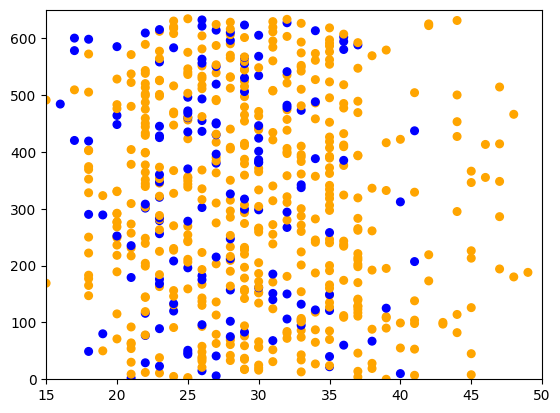

In [20]:
f1 = data['edad_en_billboard'].values
f2 = data.index

colores = ['orange','blue','green']

asignar=[]
for index, row in data.iterrows():    
    if (valores_nulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

## Mapeo de datos

A continuación, se transformaran los datos de entrada en valores categóricos. Las edades, se separaran los siguientes rangos: menor a 21, entre 21 y 26, etc. al igual que las duraciones de las canciones, por ejemplo: entre 150 y 180 segundos, etc. 

In [21]:
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,37


In [22]:
interval_age = (0, 21, 26, 30, 40)
categories_age = ["young", "Adult", "older adult", "Old"]
data['age_cats'] = pd.cut(data['edad_en_billboard'], interval_age, labels=categories_age)

data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,age_cats
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,Old
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,Adult
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,young
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,Adult
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,37,Old


In [23]:
interval_song = (0, 150, 180, 210, 240, 270, 300)
cats_song = ['short', 'medium', 'medium-long', 'long', 'extra-long', 'extra-extra-long']
data['duration_cats'] = pd.cut(data['durationSeg'], interval_song, labels=cats_song)

data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard,age_cats,duration_cats
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39,Old,medium-long
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25,Adult,NaN
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21,young,long
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25,Adult,medium-long
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,37,Old,long


In [24]:
target = data['top']
features = data[['mood','tempo','genre','artist_type','age_cats','duration_cats']]

In [25]:
features.head()

,mood,tempo,genre,artist_type,age_cats,duration_cats
0,Brooding,Medium Tempo,Traditional,Male,Old,medium-long
1,Energizing,Medium Tempo,Pop,Female,Adult,NaN
2,Excited,Medium Tempo,Urban,Mixed,young,long
3,Brooding,Medium Tempo,Alternative & Punk,Male,Adult,medium-long
4,Yearning,Medium Tempo,Traditional,Female,Old,long


In [26]:
# Obtener los valores únicos de cada columna
for column in features.columns:
    unique_values = features[column].unique()
    print(f"Columna: {column}")
    print(f"Valores únicos: {unique_values}")
    print("\n")

Columna: mood
Valores únicos: ['Brooding' 'Energizing' 'Excited' 'Yearning' 'Upbeat' 'Cool' 'Urgent'
 'Aggressive' 'Sophisticated' 'Defiant' 'Sensual' 'Empowering' 'Gritty'
 'Romantic' 'Rowdy' 'Other' 'Fiery' 'Sentimental' 'Easygoing' 'Stirring'
 'Melancholy' 'Peaceful' 'Lively']


Columna: tempo
Valores únicos: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']


Columna: genre
Valores únicos: ['Traditional' 'Pop' 'Urban' 'Alternative & Punk' 'Electronica' 'Other'
 'Soundtrack' 'Rock' 'Jazz']


Columna: artist_type
Valores únicos: ['Male' 'Female' 'Mixed']


Columna: age_cats
Valores únicos: ['Old', 'Adult', 'young', 'older adult', NaN]
Categories (4, object): ['young' < 'Adult' < 'older adult' < 'Old']


Columna: duration_cats
Valores únicos: ['medium-long', NaN, 'long', 'short', 'extra-long', 'extra-extra-long', 'medium']
Categories (6, object): ['short' < 'medium' < 'medium-long' < 'long' < 'extra-long' < 'extra-extra-long']




In [27]:
# Aplica LabelEncoder a age_cats
label_encoder = LabelEncoder()
features['age_cats'] = label_encoder.fit_transform(features['age_cats'])

# Aplica get dummies al resto de las columnas
features = pd.get_dummies(features, columns=['mood', 'tempo', 'genre', 'artist_type', 'duration_cats'], drop_first=True)

features.head()

C:\Users\Electro\AppData\Local\Temp\ipykernel_5504\3253828569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['age_cats'] = label_encoder.fit_transform(features['age_cats'])


,age_cats,mood_Brooding,mood_Cool,mood_Defiant,mood_Easygoing,mood_Empowering,mood_Energizing,mood_Excited,mood_Fiery,mood_Gritty,...,genre_Soundtrack,genre_Traditional,genre_Urban,artist_type_Male,artist_type_Mixed,duration_cats_medium,duration_cats_medium-long,duration_cats_long,duration_cats_extra-long,duration_cats_extra-extra-long
0,1,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## Diseño del árbol

In [28]:
y = target
X = features

In [29]:
#Separa el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16) 

criterio ='entropy'
arbol = DecisionTreeClassifier(criterion=criterio, random_state=16)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=16)

In [30]:
# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
accuracy

NameError: name 'y_pred' is not defined

[0.17826817 0.01113831 0.05310064 0.03283435 0.         0.03405989
 0.03073032 0.0292653  0.00593101 0.00447891 0.         0.00326955
 0.         0.         0.         0.00892409 0.02654862 0.
 0.0135083  0.         0.         0.02011979 0.00626525 0.02666511
 0.02681358 0.         0.         0.00233726 0.06665088 0.
 0.         0.09068834 0.04074057 0.02483352 0.02755487 0.01762157
 0.06576348 0.08069239 0.05388836 0.01730758]


<Axes: >

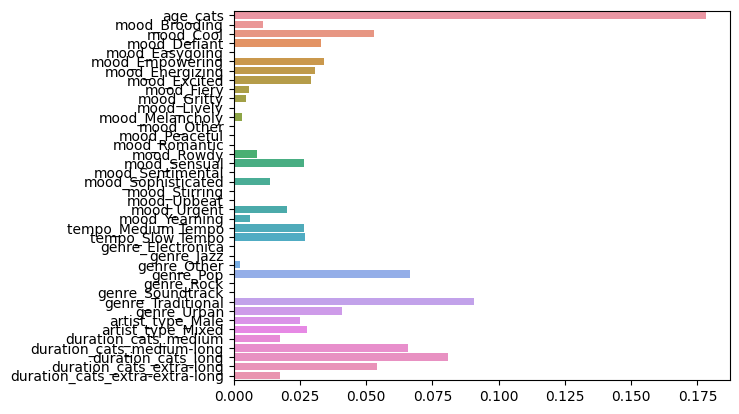

In [ ]:
#Grafica la importancia de las variables
fi = arbol.feature_importances_
print(fi)
sns.barplot(y = X_train.columns, x = fi)

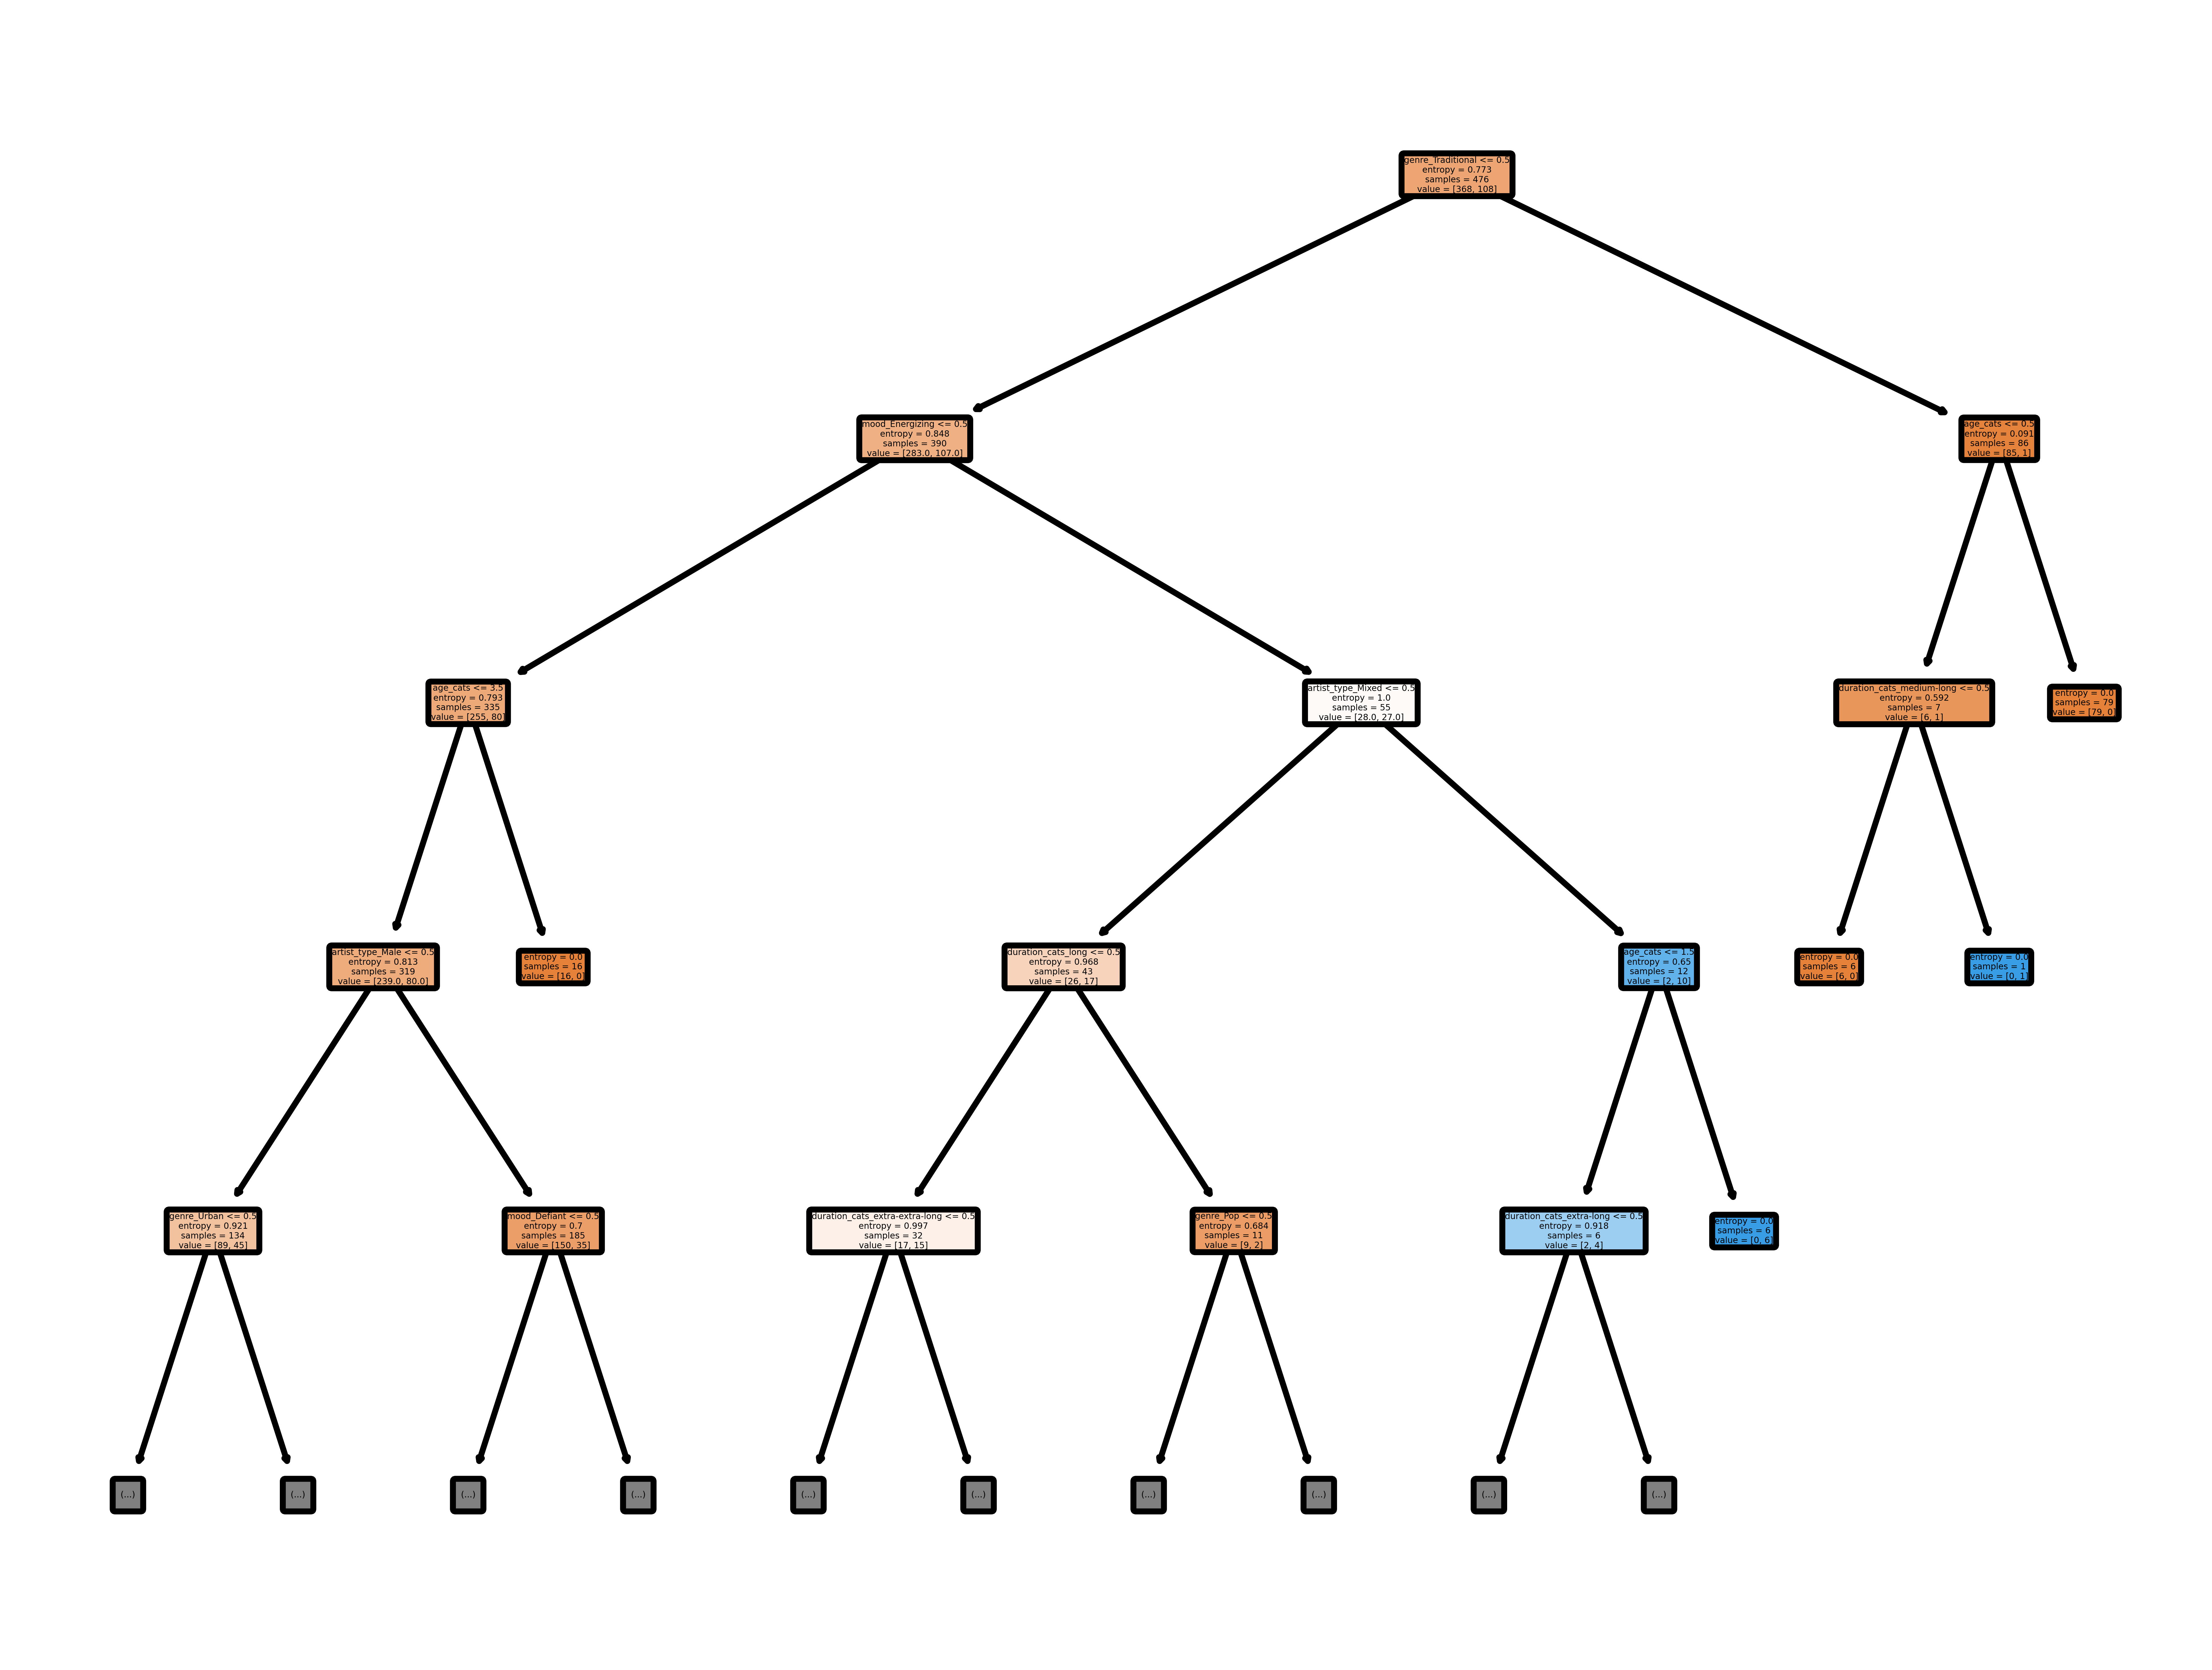

In [ ]:
#Grafica el árbol
list_features = list(X.columns)
plt.figure(dpi=1500)
plot_tree(arbol, filled=True, rounded=True, feature_names=list_features, max_depth=4)
plt.show()
plt.close()

In [ ]:
#Evaluamos el modelo
y_pred = arbol.predict(X_test)
print('Score train: ', arbol.score(X_train, y_train))
print('Score test: ', arbol.score(X_test, y_test))

Score train:  0.9558823529411765
Score test:  0.7547169811320755


In [ ]:
#Calcula la Profundidad del árbol
print(f'Máxima profundidad:  {arbol.get_depth()}')
#Calcula el número de hojas del árbol
print(f'Cantidad de hojas: {arbol.get_n_leaves()}')

Máxima profundidad:  23
Cantidad de hojas: 153


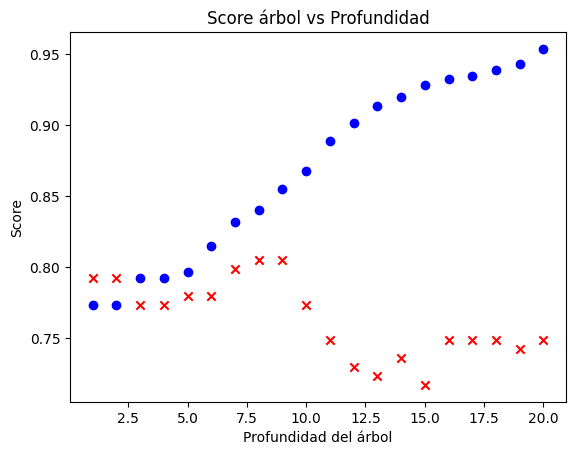

In [ ]:
#Calcula la Profundidad del árbol y el score que tiene los set de entrenamiento y testeo
depth = [i+1 for i in range(20)]
score_train = []
score_test = []
for dep in depth:
    tree = DecisionTreeClassifier(criterion=criterio, max_depth=dep, random_state=16)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    '''
    print(f'Profundidad: {dep}')
    print(f'Precision train: {tree.score(X_train, y_train)}')
    print(f'Precision test: {tree.score(X_test, y_test)}')
    '''
    score_train.append(tree.score(X_train, y_train))
    score_test.append(tree.score(X_test, y_test))


#Grafica 
plt.scatter(x=depth, y=score_train, marker='o', color='blue')
plt.scatter(x=depth, y=score_test, marker='x', color='red')
plt.title('Score árbol vs Profundidad')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Score')
plt.show()

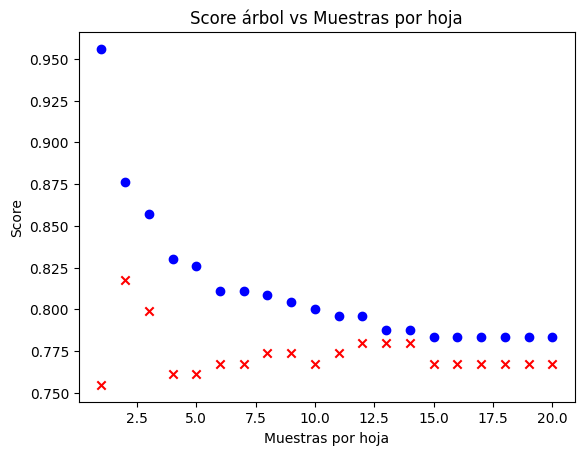

In [ ]:
#Regula la cantidad de muestras minima por hoja
samplex = [i+1 for i in range(20)]
score_train1 = []
score_test1 = []
for sam in samplex:
    tree = DecisionTreeClassifier(criterion=criterio, min_samples_leaf=sam, random_state=16)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    '''
    print(f'Profundidad: {sam}')
    print(f'Precision train: {tree.score(X_train, y_train)}')
    print(f'Precision test: {tree.score(X_test, y_test)}')
    '''
    score_train1.append(tree.score(X_train, y_train))
    score_test1.append(tree.score(X_test, y_test))

#Grafica
plt.scatter(x=samplex, y=score_train1, marker='o', color='blue')
plt.scatter(x=samplex, y=score_test1, marker='x', color='red')
plt.title('Score árbol vs Muestras por hoja')
plt.xlabel('Muestras por hoja')
plt.ylabel('Score')
plt.show()

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

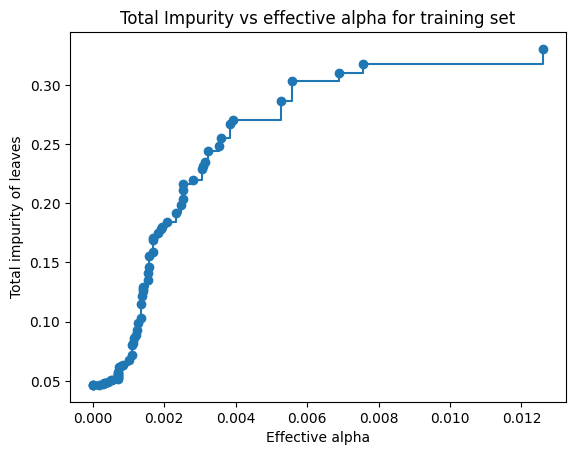

In [ ]:
#poda posterior, ccpalfa (cost complexity pruning path)
clas = DecisionTreeClassifier(random_state=16)
path = clas.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=16, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.020436287742498838


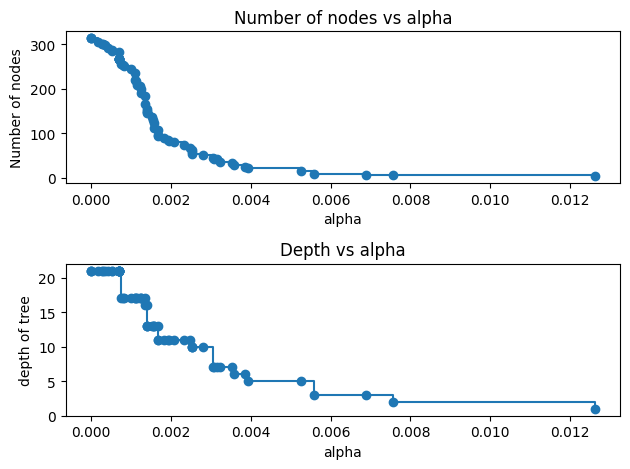

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

#Calcula la cantidad de nodos y la profundidad para cada clasificador
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

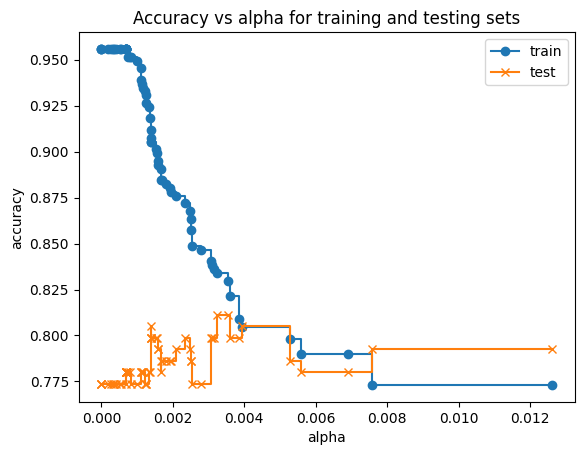

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
               
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='x', label='test', drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
alfas = ccp_alphas
scor = np.array(test_scores)

alfa_score = pd.DataFrame({'alpha':alfas, 'score':scor})
indice = alfa_score['score'].idxmax()
alfa_max = alfa_score['alpha'].iloc[indice]
print('Mejor alfa:', alfa_max)

Mejor alfa: 0.0032306995678565106


In [ ]:
alfas = ccp_alphas
sco = np.array(test_scores)
score = np.array(train_scores)
alfa_score = pd.DataFrame({'alpha':alfas, 'score_test':sco, 'score_train':score})
alfa_score['diferencia'] = alfa_score['score_train'] - alfa_score['score_test']
index = alfa_score['diferencia'].idxmin()
alfa_best = alfa_score['alpha'].iloc[index]
print('Mejor alfa:', alfa_best)

Mejor alfa: 0.007561840803974859


Score train:  0.7899159663865546
Score test:  0.779874213836478


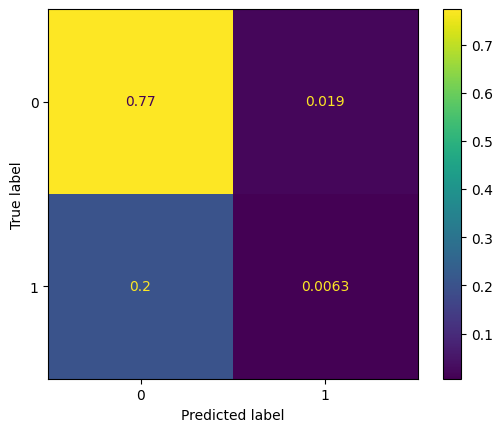

In [ ]:
arbol_alfa = DecisionTreeClassifier(criterion = criterio, random_state= 16, ccp_alpha=alfa_max, max_depth=6, min_samples_leaf=9)
arbol_alfa.fit(X_train, y_train)
y_pred_alfa = arbol_alfa.predict(X_test)
print('Score train: ', arbol_alfa.score(X_train, y_train))
print('Score test: ', arbol_alfa.score(X_test, y_test))
cm_alfa = confusion_matrix(y_test, y_pred_alfa, normalize='all')
ConfusionMatrixDisplay(cm_alfa).plot()

[0.07670748 0.         0.         0.05837841 0.         0.
 0.11752364 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.10806142 0.
 0.         0.34682431 0.09516954 0.07522564 0.06578221 0.
 0.03031434 0.02601302 0.         0.        ]


<Axes: >

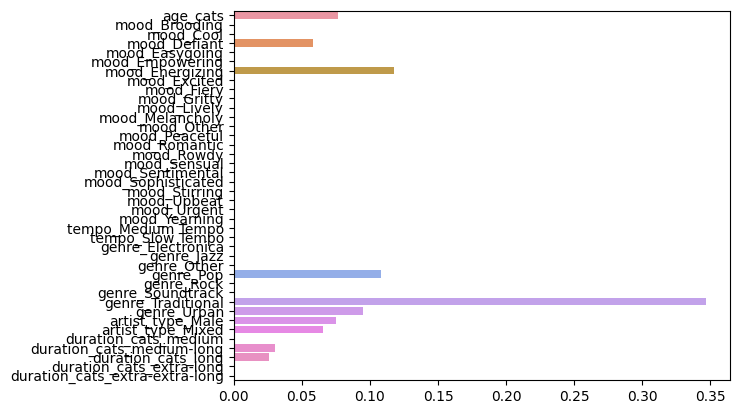

In [ ]:
#Grafica la importancia de las variables
fi = arbol_alfa.feature_importances_
print(fi)
sns.barplot(y = X_train.columns, x = fi)

In [ ]:
#Simulación de predicción
camila = {'age_cats': [2], 'mood_Brooding': [0], 'mood_Cool': [0], 'mood_Defiant': [0],
       'mood_Easygoing': [0], 'mood_Empowering': [0], 'mood_Energizing': [0], 'mood_Excited': [0],
       'mood_Fiery': [0], 'mood_Gritty': [0], 'mood_Lively': [0], 'mood_Melancholy': [0],
       'mood_Other': [0], 'mood_Peaceful': [0], 'mood_Romantic': [1], 'mood_Rowdy': [0],
       'mood_Sensual': [0], 'mood_Sentimental': [0], 'mood_Sophisticated': [0],
       'mood_Stirring': [0], 'mood_Upbeat': [0], 'mood_Urgent': [0], 'mood_Yearning': [0],
       'tempo_Medium Tempo': [1], 'tempo_Slow Tempo': [0], 'genre_Electronica': [0],
       'genre_Jazz': [0], 'genre_Other': [0], 'genre_Pop': [1], 'genre_Rock': [0],
       'genre_Soundtrack': [0], 'genre_Traditional': [0], 'genre_Urban': [0],
       'artist_type_Male': [0], 'artist_type_Mixed': [0], 'duration_cats_medium': [0],
       'duration_cats_medium-long': [0], 'duration_cats_long': [1],
       'duration_cats_extra-long': [0], 'duration_cats_extra-extra-long': [0]}
pd_camila = pd.DataFrame.from_dict(camila)

print('camila llegara al puesto 1?', arbol_alfa.predict(pd_camila))

camila llegara al puesto 1? [0]


In [ ]:
# Predicción
prediccion = arbol_alfa.predict(pd_camila)[0]
probabilidades = arbol_alfa.predict_proba(pd_camila)[0]

# Mostrar resultados
print('¿Camila llegará al puesto 1?', 'Sí' if prediccion == 1 else 'No')
print('Probabilidad de no llegar al puesto 1:', probabilidades[0])
print('Probabilidad de llegar al puesto 1:', probabilidades[1])

¿Camila llegará al puesto 1? No
Probabilidad de no llegar al puesto 1: 0.6285714285714286
Probabilidad de llegar al puesto 1: 0.37142857142857144


## Validación cruzada

In [ ]:
# Lista para almacenar los puntajes de validación para cada valor de alpha
alpha_scores = []

# Iterar sobre cada valor de alpha
for ccp_alpha in ccp_alphas:
    # Crear y entrenar el árbol de decisión con el valor actual de alpha
    clas = DecisionTreeClassifier(random_state=16, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clas, X_train, y_train, cv=5)  # 5-fold cross-validation
    alpha_scores.append(scores.mean())

# Encontrar el valor de alpha que maximiza la puntuación de validación cruzada
optimal_alpha = ccp_alphas[np.argmax(alpha_scores)]

print(f'Optimal alpha: {optimal_alpha}')

Optimal alpha: 0.005268295515973534


Score train:  0.7899159663865546
Score test:  0.779874213836478


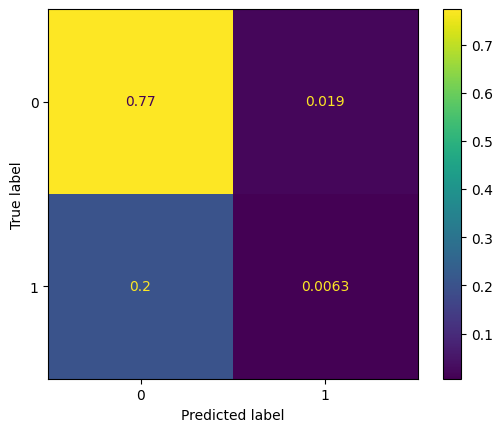

In [ ]:
arbol_alfa2 = DecisionTreeClassifier(criterion = criterio, random_state= 16, ccp_alpha=optimal_alpha, max_depth=3, min_samples_leaf=5)
arbol_alfa2.fit(X_train, y_train)
y_pred_alfa = arbol_alfa2.predict(X_test)
print('Score train: ', arbol_alfa2.score(X_train, y_train))
print('Score test: ', arbol_alfa2.score(X_test, y_test))
cm_alfa = confusion_matrix(y_test, y_pred_alfa, normalize='all')
ConfusionMatrixDisplay(cm_alfa).plot()

[0.18550748 0.         0.         0.         0.         0.
 0.18056344 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.53286122 0.         0.         0.10106785 0.
 0.         0.         0.         0.        ]


<Axes: >

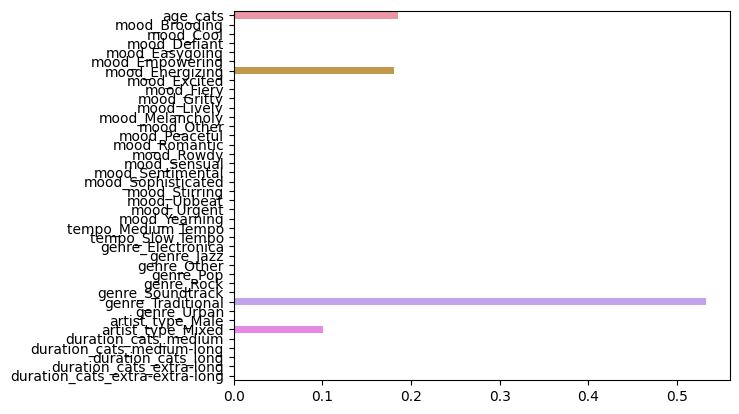

In [ ]:
#Grafica la importancia de las variables
fi = arbol_alfa2.feature_importances_
print(fi)
sns.barplot(y = X_train.columns, x = fi)

In [ ]:
#Simulación de predicción
camila = {'age_cats': [2], 'mood_Brooding': [0], 'mood_Cool': [0], 'mood_Defiant': [0],
       'mood_Easygoing': [0], 'mood_Empowering': [0], 'mood_Energizing': [0], 'mood_Excited': [0],
       'mood_Fiery': [0], 'mood_Gritty': [0], 'mood_Lively': [0], 'mood_Melancholy': [0],
       'mood_Other': [0], 'mood_Peaceful': [0], 'mood_Romantic': [1], 'mood_Rowdy': [0],
       'mood_Sensual': [0], 'mood_Sentimental': [0], 'mood_Sophisticated': [0],
       'mood_Stirring': [0], 'mood_Upbeat': [0], 'mood_Urgent': [0], 'mood_Yearning': [0],
       'tempo_Medium Tempo': [1], 'tempo_Slow Tempo': [0], 'genre_Electronica': [0],
       'genre_Jazz': [0], 'genre_Other': [0], 'genre_Pop': [1], 'genre_Rock': [0],
       'genre_Soundtrack': [0], 'genre_Traditional': [0], 'genre_Urban': [0],
       'artist_type_Male': [0], 'artist_type_Mixed': [0], 'duration_cats_medium': [0],
       'duration_cats_medium-long': [0], 'duration_cats_long': [1],
       'duration_cats_extra-long': [0], 'duration_cats_extra-extra-long': [0]}
pd_camila = pd.DataFrame.from_dict(camila)

print('camila llegara al puesto 1?', arbol_alfa2.predict(pd_camila))

camila llegara al puesto 1? [0]


In [ ]:
# Predicción
prediccion = arbol_alfa2.predict(pd_camila)[0]
probabilidades = arbol_alfa2.predict_proba(pd_camila)[0]

# Mostrar resultados
print('¿Camila llegará al puesto 1?', 'Sí' if prediccion == 1 else 'No')
print('Probabilidad de no llegar al puesto 1:', probabilidades[0])
print('Probabilidad de llegar al puesto 1:', probabilidades[1])

¿Camila llegará al puesto 1? No
Probabilidad de no llegar al puesto 1: 0.7492163009404389
Probabilidad de llegar al puesto 1: 0.2507836990595611
